In [1]:
%%html
<style>
table {float:left}
</style>

## Tf-Idf & Multinomial NB

- tokenizing/POS tagging $\rightarrow$ tf-idf vectorization
- Model: Multinomial Naive Bayes
- Data: 165,810 reviews

### Modeling

- Without Oversampling
- With Oversampling

### Results

|                      | Accuracy | Recall | F1-Score |
|----------------------|:--------:|:------:|:--------:|
| Without Oversampling |   0.79   |  0.79  |   0.79   |
| With Oversampling    |   0.85   |  0.86  |   0.85   |

- Before oversampling, recall of 역겹다/슬프다/무섭다 is lower than precision.
- After oversampleing, recall of those labels is improved.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from collections import Counter

from file_io import *
from words_preprocessing import *

In [3]:
train_joy = read_data('../train_data_labeled_joy.txt')
train_anger = read_data('../train_data_labeled_anger.txt')
train_disgust = read_data('../train_data_labeled_disgust.txt')
train_sadness = read_data('../train_data_labeled_sadness.txt')
train_fear = read_data('../train_data_labeled_fear.txt')

trains = [train_joy, train_anger, train_disgust, train_sadness, train_fear]
labels = ['기쁘다', '화나다', '역겹다', '슬프다', '무섭다']

num_dic = {}
for label, data in zip(labels, trains):
    num_dic[label] = len(data)
label_count = Counter(num_dic)
sum_ = sum(label_count.values())
print("Number of Data: ", sum_)
print(label_count)
print()

for label in label_count.keys():
    print(label ,": {}%".format(round(label_count[label] / sum_, 2)))

Number of Data:  165810
Counter({'기쁘다': 73614, '화나다': 40501, '슬프다': 20701, '역겹다': 20390, '무섭다': 10604})

기쁘다 : 0.44%
화나다 : 0.24%
역겹다 : 0.12%
슬프다 : 0.12%
무섭다 : 0.06%


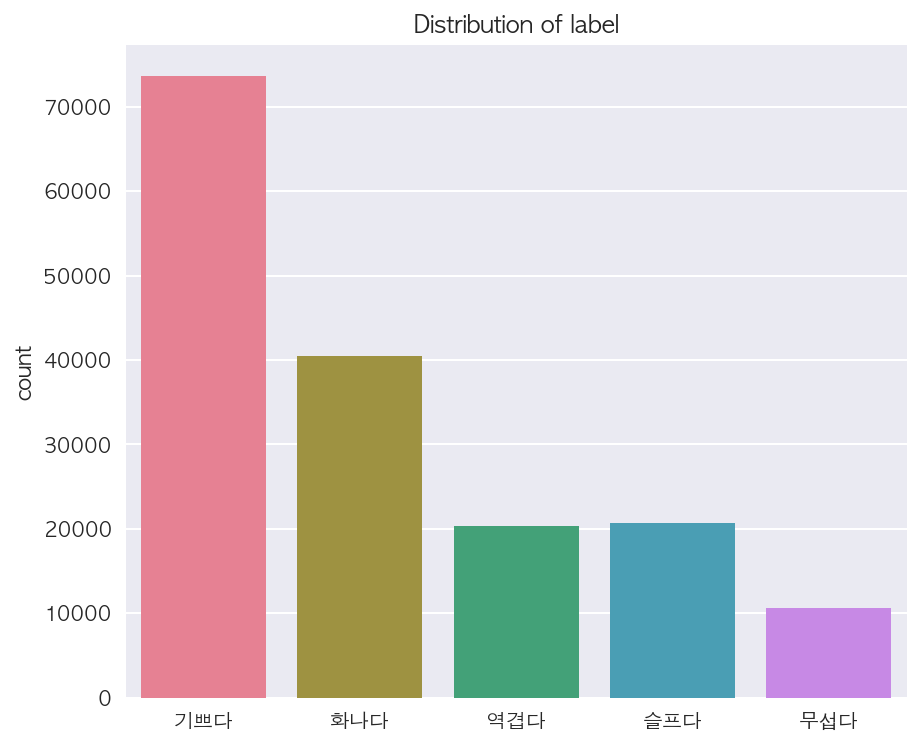

In [4]:
df = pd.DataFrame(list(label_count.values()), 
                  index=list(label_count.keys()), 
                  columns=['count'])

plt.figure(figsize=(7, 6))
plt.title("Distribution of label")
sns.barplot(x=df.index, y=df['count'], data=df, palette='husl');

- Imbalanced distribution of labels.
    1. Number of reviews of horror movies are small.
    2. Most of positive emotions are labeled as 기쁘다.

In [5]:
train_joy_labeled = [(row, 0) for row in train_joy]
train_anger_labeled = [(row, 1) for row in train_anger]
train_disgust_labeled = [(row, 2) for row in train_disgust]
train_sadness_labeled = [(row, 3) for row in train_sadness]
train_fear_labeled = [(row, 4) for row in train_fear]

train_lst = [train_joy_labeled, train_anger_labeled, 
             train_disgust_labeled, train_sadness_labeled, train_fear_labeled]

In [6]:
train = []
for data in train_lst:
    train += data

print(len(train))

165810


In [7]:
train[100]

(["'본격사심방송' 보다가 발견한 영화. 기대안했는데 유쾌한 유치함이 기분좋게 해주는 영화인듯. 추천합니다"], 0)

In [8]:
%%time
train_docs = [(tokenize(row[0][0]), row[1]) for row in train]

CPU times: user 2min 57s, sys: 988 ms, total: 2min 58s
Wall time: 2min 48s


In [9]:
save_pickle('../train_labeled_0505.pickle', train)
save_pickle('../train_docs_0505.pickle', train_docs)

In [10]:
y0 = [row[1] for row in train_docs]
x0 = [' '.join(row[0]) for row in train_docs]

X_train, X_test, y_train, y_test = train_test_split(x0, y0, 
                                                    random_state=1234)

len(X_train), len(X_test), len(y_train), len(y_test)

(124357, 41453, 124357, 41453)

In [11]:
clf = Pipeline([
    ('vect', TfidfVectorizer(min_df=30, ngram_range=(1, 3))), 
    ('clf', MultinomialNB(alpha=0.001)),    
])

model = clf.fit(X_train, y_train)
model

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=30,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

In [12]:
%%time
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross validation score: {}".format(scores))

Cross validation score: [ 0.79556967  0.7884368   0.79051908  0.79179735  0.7871733 ]
CPU times: user 54.2 s, sys: 1.84 s, total: 56.1 s
Wall time: 57.1 s


In [13]:
y_pred = model.predict(X_test)

In [14]:
print(confusion_matrix(y_test, y_pred))

[[16369   881   268   752   186]
 [ 1212  7986   480   236   181]
 [  523   798  3547   143    47]
 [ 1162   473   107  3384    95]
 [  402   371    93   126  1631]]


In [15]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.89      0.86     18456
          1       0.76      0.79      0.78     10095
          2       0.79      0.70      0.74      5058
          3       0.73      0.65      0.69      5221
          4       0.76      0.62      0.68      2623

avg / total       0.79      0.79      0.79     41453



### Oversampling

In [16]:
from imblearn.over_sampling import RandomOverSampler
rnd_os = RandomOverSampler(random_state=1234)

x = np.array(x0).reshape(-1, 1)
X, y = rnd_os.fit_sample(x, y0)
X = [x[0] for x in X.tolist()]

len(X), len(y)

(368070, 368070)

In [17]:
Counter(y)

Counter({0: 73614, 1: 73614, 2: 73614, 3: 73614, 4: 73614})

In [18]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                        random_state=1234)

len(X_train2), len(X_test2), len(y_train2), len(y_test2)

(276052, 92018, 276052, 92018)

In [19]:
clf2 = Pipeline([
    ('vect', TfidfVectorizer(min_df=10, ngram_range=(1, 3))), 
    ('clf', MultinomialNB(alpha=0.001)),    
])

model2 = clf2.fit(X_train2, y_train2)
model2

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

In [20]:
%%time
scores2 = cross_val_score(clf2, X_train2, y_train2, cv=5)
print("Cross validation score: {}".format(scores2))

Cross validation score: [ 0.84307759  0.84455996  0.84396225  0.84075349  0.84225112]
CPU times: user 1min 55s, sys: 3.87 s, total: 1min 58s
Wall time: 1min 59s


In [21]:
y_pred2 = model2.predict(X_test2)

In [22]:
print(confusion_matrix(y_test2, y_pred2))

[[14164  1179   699  1822   546]
 [ 1244 14801  1220   615   499]
 [  585  1009 16226   327   163]
 [ 1041   718   349 16057   286]
 [  290   332   176   210 17460]]


In [23]:
print(classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

          0       0.82      0.77      0.79     18410
          1       0.82      0.81      0.81     18379
          2       0.87      0.89      0.88     18310
          3       0.84      0.87      0.86     18451
          4       0.92      0.95      0.93     18468

avg / total       0.85      0.86      0.85     92018



- 오버샘플링 이후 recall 상승
- precision/recall 크게 상승 (특히 역겹다/슬프다/무섭다)

In [24]:
save_pickle('../model/mnb_0505.pickle', model)
save_pickle('../model/mnb_0505_ov.pickle', model2)